In [50]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Problem Intro

We will explore the effect of dropout on a simple gradient descent problem. We will train weights $w_1$ and $w_2$ to solve the linear equation $10w_1 + w_2 = 11$, where $w_1$ and $w_2$ are initialized at 0.

We formulate this question as an OLS:

$$\min_{\mathbf{w}} \lVert \mathbf{Xw} - \mathbf{y} \rVert^2 $$,

where $\mathbf{X}, \mathbf{y}$ are:

In [51]:
x = np.array([[10, 1]])
y = np.array([[11]])

## No Dropout, Least-Square

Analytically show what solution we will converge to if we train with gradient descent and an appropriately small learning rate. Take advantage of the fact that when you initialize weights to 0 and train linear regression with gradient descent, you recover the least-squares solution.

**Complete the following code** to calculate this solution in python, but you can also use another tool and insert your answer.
(HINT: use `np.linalg.pinv`)

In [52]:
################################################################################
# TODO: YOUR CODE HERE
w=np.linalg.pinv(x)@y
################################################################################
################################################################################

print(w)

[[1.08910891]
 [0.10891089]]


### Question

Please **include the mathematical expression in your written** assignment submission, and **copy and paste the output of the previous cell** into your submission as well.

## No Dropout, Gradient Descent

Show training with gradient descent recovers the expected solution. A training loop has been provided for you.

In [53]:
def train_simple(net, lr=.001, batch_size=1, itrs=1000, plot=True, optim_class=torch.optim.SGD, x=None, y=None):
    optimizer = optim_class(net.parameters(), lr=lr)

    losses = []
    if x is None:
        x = torch.FloatTensor([[10, 1]])
        y = torch.FloatTensor([[11]])
    else:
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
    # Repeat element batch_size times
    x = x.repeat(batch_size, 1)
    y = y.repeat(batch_size, 1)
    for i in range(itrs):
        y_hat = net(x)
        loss = torch.nn.MSELoss()(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if plot:
        plt.plot(losses)
        plt.show()
        print_weights(net)
    return losses

def print_weights(net):
  print(f'Weights: {net.state_dict().values()}')

**Complete the following code to create the linear network for the OLS in PyTorch.**

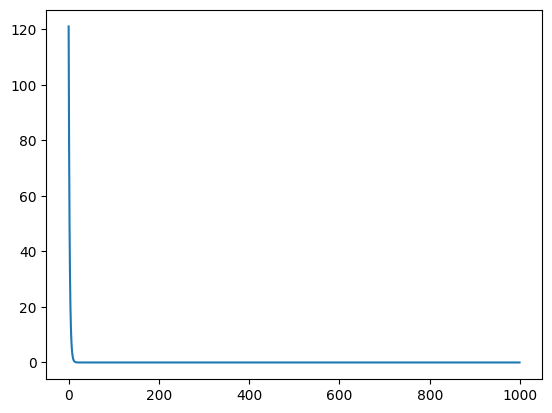

Weights: odict_values([tensor([[1.0891, 0.1089]])])


In [54]:
################################################################################
# TODO: YOUR CODE HERE
net=nn.Sequential(nn.Linear(2,1,bias=False))
################################################################################
################################################################################

# Initialize weights with 0
net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
losses = train_simple(net)

### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment. **Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Least-Square

Now we add a dropout rate of `p=0.5`, which means that during each forward pass, each input to the network has a 50% probability of being set to `0`. To account for this reduction in the number of inputs, we also need to scale the inputs by `2`. However, during testing, we do not apply any dropout, nor do we scale the inputs.

By dropping out each element in the input with a 50% probability, we create a dataset with *four* equally likely inputs, in which $w_1$ is dropped out, $w_2$ is dropped out, both are dropped out, or neither is dropped out. This is our new dataset, represented by `x` and `y`. Using this dataset, we can compute the analytic solution to improve our network's performance.

**Complete the following code according to the instructions above:**

In [61]:
################################################################################
# TODO: YOUR CODE HERE
import random
j=0
for i in range(len(x)):
  if random.random()<0.5:
    x[j]=x[i]
    y[j]=y[i]
    j+=1
x=x[:j]
y=y[:j]
x=np.concatenate((x,x), axis=0)
y=np.concatenate((y,y), axis=0)
w=np.linalg.pinv(x)@y
################################################################################
################################################################################
print("x =", x)
print("y =", y)
print("w =", w)

x = [[10  1]
 [10  1]
 [10  1]
 [10  1]]
y = [[11]
 [11]
 [11]
 [11]]
w = [[1.08910891]
 [0.10891089]]


### Question

Please **copy and paste the output of the previous cell** (text only) into your submission of the written assignment.

## Dropout, Gradient Descent
**Add dropout to your network. Implement the Dropout layer below, then run with dropout.**

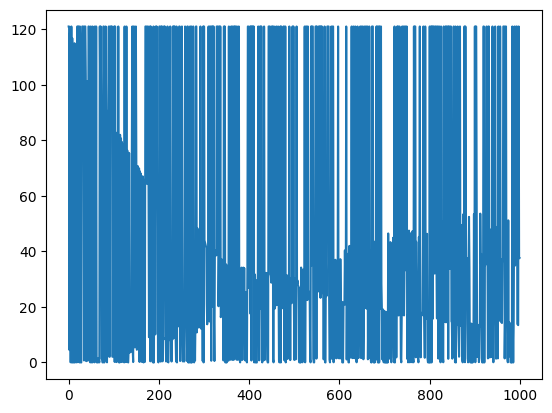

Weights: odict_values([tensor([[0.4887, 3.6570]])])


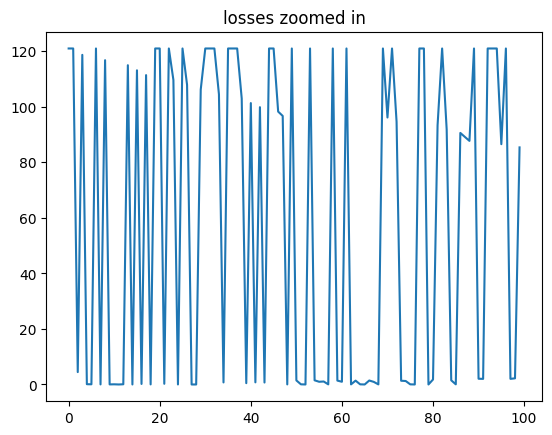

In [63]:
class Dropout(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            ####################################################################
            # TODO: YOUR CODE HERE
            dropout=nn.Dropout(self.p)
            return dropout(x)
            ####################################################################
            ####################################################################
        else:
            return x

def init_with_dropout(p):
    net = torch.nn.Sequential(
        Dropout(p),
        torch.nn.Linear(2, 1, bias=False)
    )
    # Initialize weights with 0
    net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
    return net

net = init_with_dropout(0.5)
losses = train_simple(net)
plt.title('losses zoomed in')
plt.plot(losses[:100])
plt.show()

### Question

**Describe the shape of the training curve. Are the weights obtained by training with gradient descent the same as those calculated using the closed-form least squares method?** Answer this question in your written assignment.

## Dropout, Gradient Descent with Larger Batch Sizes

Run the cell below, which uses a larger batch.

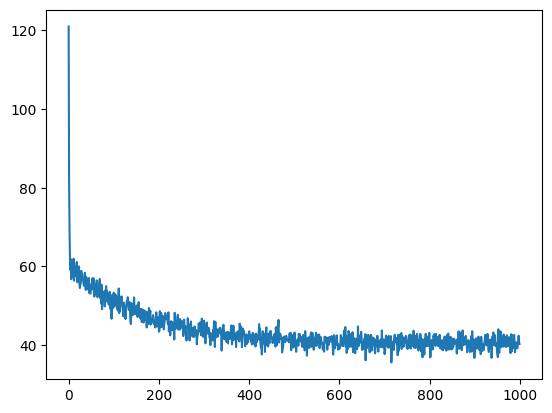

Weights: odict_values([tensor([[0.3812, 3.4844]])])


In [64]:
net = init_with_dropout(0.5)
losses = train_simple(net, batch_size=1024)

### Question

**Describe the loss curve and compare it with the loss curve in the last part. Why are they different? Also compare the trained weights with the one calculated by the least-square formula.** Answer this question in your written assignment.

# (G) [OPTIONAL]: Sweeping over dropout rate

Now, let's see how different dropout rates affect the final solution. Run the cell below to sweep over dropout rates. Since the 4 data points we considered in part (C) are no longer equally likely, we need to weight each data point by its probability of occuring. This turns it into a weighted linear regression problem. The analytic solution for this problem is:

$$w = (X^\top S X)^{-1} X^\top S y$$

where $S$ is the diagonal matrix of probabilities of each data point occuring.

Implement the analytic solution in the cell below, and show that the analytic solution matches the empirical solution. You should see that as the dropout rate changes, $w_1$ and $w_2$ change smoothly, except for a discontinuity when dropout rates are 0. Explain this discontinuity.

In [1]:
def init_with_dropout(p):
    net = torch.nn.Sequential(
        Dropout(p),
        torch.nn.Linear(2, 1, bias=False)
    )
    net.load_state_dict({k: v * 0 for k, v in net.state_dict().items()})
    return net

empirical_dropout_rates = [0, .1, .3, .5, .7]
analytical_dropout_rates = np.arange(0, .99, .01)
losses_empirical, losses_analytical = [], []
w1_empirical, w2_empirical, w1_analytical, w2_analytical = [], [], [], []
for p in analytical_dropout_rates:
    # compute analytical solution
    ############################################################################
    # TODO: YOUR CODE HERE

    ############################################################################
    ############################################################################
    x = np.array([[10, 1]])
    y = np.array([[11]])
    l_analytic = ((x @ w_analytic - y) ** 2).item()
    w1_analytical.append(w_analytic[0][0])
    w2_analytical.append(w_analytic[1][0])
    losses_analytical.append(l_analytic)
for p in empirical_dropout_rates:
    net = init_with_dropout(p)
    # Initialize weights with 0
    losses = train_simple(net, batch_size=1024, itrs=10000, plot=False)
    net.eval()
    losses_empirical.append(((net(torch.FloatTensor(x)) - torch.FloatTensor(y)) ** 2).item())
    w1_empirical.append(net.state_dict()['1.weight'][0][0].item())
    w2_empirical.append(net.state_dict()['1.weight'][0][1].item())
# Plot all saved values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(analytical_dropout_rates, losses_analytical, label='analytical')
plt.scatter(empirical_dropout_rates, losses_empirical, label='empirical')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(analytical_dropout_rates, w1_analytical, label='w1 analytical')
plt.scatter(empirical_dropout_rates, w1_empirical, label='w1 empirical')
plt.plot(analytical_dropout_rates, w2_analytical, label='w2 analytical')
plt.scatter(empirical_dropout_rates, w2_empirical, label='w2 empirical')
plt.legend()
plt.show()


NameError: name 'np' is not defined

# (H) [OPTIONAL]: Adding Adam

Now, let's add Adam to our network. Run the cell below to train with Adam with and without dropout. Does the solution change? Why or why not?

In [ ]:
dropout_rates = [0, .5]
optim_classes = [torch.optim.SGD, torch.optim.Adam]

# Two plots, one for w1 and one for w2
fig, axs = plt.subplots(figsize=(5, 5))

for optim_class in optim_classes:
    w1_list = []
    w2_list = []
    for p in dropout_rates:
        net = init_with_dropout(p).train()
        losses = train_simple(net, batch_size=1024, itrs=10000, optim_class=optim_class, plot=False)
        net.eval()
        w1_list.append(net.state_dict()['1.weight'][0][0].item())
        w2_list.append(net.state_dict()['1.weight'][0][1].item())
    axs.plot(dropout_rates, w1_list, label=f'{optim_class.__name__} w1')
    axs.plot(dropout_rates, w2_list, label=f'{optim_class.__name__} w2')
axs.legend()
axs.set_ylim(0, 4)
plt.show()



## (I): Dropout on real data

There are some unusual features of our previous problem:
- We only used a single datapoint
- We applied dropout to the inputs to the network, whereas in real problems it's typically applied to hidden units
- The network was so small that dropout significantly hurt performance. Typically, networks are large enough that they can fit the data well even with dropout.

To see the effect of dropout on a more realistic problem, we'll train a network on the CIFAR10 dataset and add a "cheating feature." In this case, the cheating feature consists of a few pixels in the bottom-right corner of the image which encode the class label*. We want to see how dropout helps the network learn to rely less heavily on this cheating feature. Run the next few cells and comment on how dropout affects the degree to which the network relies on the cheating feature. Which model does better on clean data?

*This is obviously a contrived cheating feature, but they can appear in real data -- for instance, if a particular camera was used to capture all images of a certain class, the model might learn to rely on subtle camera artifacts rather than the acutal image.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvNet(torch.nn.Module):
    def __init__(self, dropout_rate=0):
        super(ConvNet, self).__init__()
        in_channels = 3
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')
        img_size = 8
        self.fc1 = torch.nn.Linear(32 * img_size * img_size, 10)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        # NOTE: we apply more dropout to this network than is typical so we can emphasize the effect.
        # It's more typical to apply dropout to only the fully connected layers.
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.dropout(x, training=self.training, p=self.dropout_rate)
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x), 2))
        x = torch.nn.functional.dropout(x, training=self.training, p=self.dropout_rate)
        img_size = 8
        x = x.view(-1, 32 * img_size * img_size)
        x = torch.nn.functional.relu(self.fc1(x))
        return torch.nn.functional.log_softmax(x, dim=1)

In [ ]:
def add_cheating_feature(x_batch, y_batch):
    # Add the label on the bottom-right corner of the image, encoded in binary
    for i in range(x_batch.shape[0]):
        binary_list = [int(x) for x in bin(y_batch[i].item())[2:]]
        if len(binary_list) < 4:
            binary_list = [0] * (4 - len(binary_list)) + binary_list
        binary_label = torch.FloatTensor(binary_list) * 3
        x_batch[i, 0, -1, -4:] = binary_label
        x_batch[i, 1:, -1, -4:] = 1 - binary_label
    return x_batch

In [ ]:
# Load CIFAR10 data
from torchvision import datasets, transforms
# Nomalizing constants for CIFAR10
MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2023, 0.1994, 0.2010]
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(MEAN, STD)
                        ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(MEAN, STD)
                        ])),
    batch_size=1000, shuffle=True)



In [ ]:
# Visualize the data (note the black and white pixels in the corner)
# Images will appear to be overly saturated since matplotlib clips values outside of [0, 1]
def visualize_data():
    for _ in range(5):
        # Get a batch of training data
        x_batch, y_batch = next(iter(train_loader))
        # Add the cheating feature
        x_batch = add_cheating_feature(x_batch, y_batch)
        # Plot the first image in the batch, with the cheating feature
        # Move the channels to the end
        x_batch = x_batch.permute(0, 2, 3, 1)
        # Undo the normalization
        x_batch = x_batch * torch.FloatTensor(STD).view(1, 1, 1, 3) + torch.FloatTensor(MEAN).view(1, 1, 1, 3)
        plt.imshow(x_batch[0])
        plt.show()
visualize_data()

In [ ]:
# Train the model
def train(model, num_epochs=15, lr=1e-3):
    all_train_losses = []
    all_val_losses = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs + 1):
        train_losses = []
        model.train()
        for (data, target) in train_loader:
            # Put the data on the same device as the model
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            # add cheating feature
            data = add_cheating_feature(data, target)
            output = model(data)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            loss.backward()
            train_losses.append(loss.item())
            train_losses = train_losses[-100:]
            optimizer.step()
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                # Put the data on the same device as the model
                data = data.to(device)
                target = target.to(device)
                # add cheating feature
                data = add_cheating_feature(data, target)
                output = model(data)
                test_loss += torch.nn.CrossEntropyLoss(reduction='sum')(output, target).item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        train_loss = np.mean(train_losses)
        print('Train Epoch: {} of {} Train Loss: {:.3f}, Val Loss: {:3f}, Val Accuracy: {:3f}'.format(
                    epoch, num_epochs, train_loss, test_loss, 100. * correct / len(test_loader.dataset)))
        all_train_losses.append(train_loss)
        all_val_losses.append(test_loss)
    plt.plot(all_train_losses)
    plt.plot(all_val_losses)
    plt.legend(['train', 'val'])
    plt.show()
    return all_train_losses, all_val_losses

In [ ]:
# Test how much the model uses the cheating feature
def test_cheating(model):
    model.eval()
    correct_cheating = 0
    correct_not_cheating = 0
    correct_random = 0
    for data, target in test_loader:
        # Put the data on the same device as the model
        data = data.to(device)
        target = target.to(device)
        # Test on clean data
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct_not_cheating += pred.eq(target.data.view_as(pred)).cpu().sum()
        # Test on data with cheating feature
        data_modified = add_cheating_feature(data.clone(), target)
        output = model(data_modified)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct_cheating += pred.eq(target.data.view_as(pred)).cpu().sum()
        correct_random += pred.eq(target.data.view_as(pred)).cpu().sum()
    print('Accuracy on clean data: {}/{} ({:.0f}%)'.format(
        correct_not_cheating, len(test_loader.dataset),
        100. * correct_not_cheating / len(test_loader.dataset)))
    print('Accuracy on data with cheating feature: {}/{} ({:.0f}%)'.format(
        correct_cheating, len(test_loader.dataset),
        100. * correct_cheating / len(test_loader.dataset)))

In [ ]:
model_no_dropout = ConvNet(dropout_rate=0)
# Put the model on the GPU, if available
model_no_dropout.to(device)
train_loss, val_loss = train(model_no_dropout, num_epochs=10, lr=3e-3)
test_cheating(model_no_dropout)

In [ ]:
model_dropout = ConvNet(dropout_rate=0.75)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dropout.to(device)
train_loss, val_loss = train(model_dropout, num_epochs=10, lr=3e-3)
test_cheating(model_dropout)